In [131]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [132]:
df = pd.read_parquet('data/fhv_tripdata_2021-01.parquet')

In [133]:
df.sample(3)

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
335502,B00856,2021-01-10 17:49:20,2021-01-10 18:16:03,NaN,129.0,None,B03209
698165,B02429,2021-01-20 08:57:13,2021-01-20 08:59:58,210.0,NaN,None,B02429
412573,B02832,2021-01-12 14:30:00,2021-01-12 15:00:00,264.0,264.0,None,B02832


**Q1. Downloading the data**

In [134]:
df.shape

(1154112, 7)

**Q2. Computing duration**

In [135]:
df['duration'] = df.dropOff_datetime - df.pickup_datetime
df['duration'] = df.duration.apply(lambda x: x.total_seconds() / 60)

In [136]:
df['duration'].mean()

19.1672240937939

*Data preparation*

/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


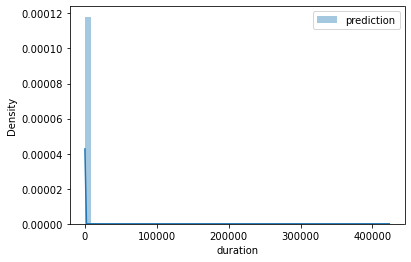

In [137]:
sns.distplot(df['duration'] , label='prediction')
plt.legend()

/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='duration'>

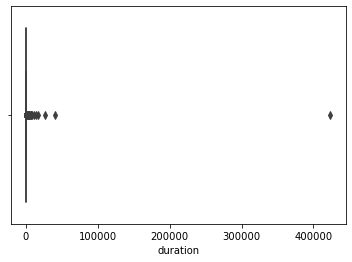

In [138]:
sns.boxplot(df['duration'])

In [139]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [140]:
1154112 - df.shape[0]

44286

/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


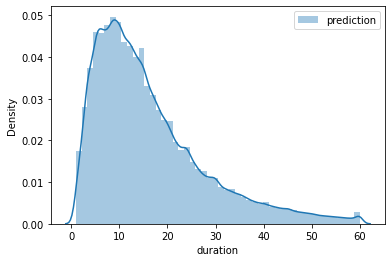

In [141]:
sns.distplot(df['duration'] , label='prediction')
plt.legend()

**Q3. Missing values**

In [142]:
df.PUlocationID.isna().sum() / df.shape[0]

0.8352732770722617

In [143]:
df.PUlocationID.fillna(-1, inplace=True)
df.DOlocationID.fillna(-1, inplace=True)

#df['PUlocationID'] = 

**Q4. One-hot encoding**

In [144]:
df.sample(3)

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
466577,B00856,2021-01-13 21:35:11,2021-01-13 21:44:19,-1.0,39.0,None,B02765,9.133333
960085,B03126,2021-01-26 22:29:05,2021-01-26 22:46:45,-1.0,61.0,None,B02836,17.666667
1099585,B03002,2021-01-30 07:14:19,2021-01-30 07:37:23,-1.0,259.0,None,B03002,23.066667


In [145]:
categorical = ['PUlocationID', 'DOlocationID']
df[categorical] = df[categorical].astype(str)

In [158]:
train_dicts = df[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train_cat = dv.fit_transform(train_dicts)

In [159]:
X_train.shape

(1109826, 525)

**Q5. Training a model**

In [148]:
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train_cat, y_train)

y_pred = lr.predict(X_train_cat)

mean_squared_error(y_train, y_pred, squared=False)

10.5285191072072

**Q6. Evaluating the model**

In [149]:
df_val = pd.read_parquet('data/fhv_tripdata_2021-02.parquet')

In [150]:
df_val['duration'] = df_val.dropOff_datetime - df_val.pickup_datetime
df_val['duration'] = df_val.duration.apply(lambda x: x.total_seconds() / 60)

In [151]:
df_val = df_val[(df_val.duration >= 1) & (df_val.duration <= 60)]

In [152]:
categorical = ['PUlocationID', 'DOlocationID']
df_val[categorical] = df_val[categorical].astype(str)

In [160]:
val_dicts = df_val[categorical].to_dict(orient='records')

X_val_cat = dv.transform(val_dicts)

In [161]:
X_val_cat.shape

(990113, 525)

In [162]:
target = 'duration'
y_val = df_val[target].values

y_pred = lr.predict(X_val_cat)

mean_squared_error(y_val, y_pred, squared=False)

11.364434509982788